###Importing and visualising the Boston Housing data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [3]:
print(train_data.shape, test_data.shape)
print(train_data[0])
print(train_targets[:5])

(404, 13) (102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
[15.2 42.3 50.  21.1 17.7]


###Pre-proccesing the data

We will normalize the numerical input data, such that it will end up having a mean of 0 and a standard deviation of 1. This allows for easier fitting of the neural network. 

The test data is also normalized by using the mean and the standard deviation of the test data. 

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

###Building the neural network using Keras

In [8]:
from keras import models
from keras import layers

def build_model():

    network = models.Sequential()

    network.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))

    network.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return network

###Train the neural network using k-fold validation
Since the dataset is very small (403 samples for training), we can't afford to fully separate a validation subset from the training set. This is where the method of k-fold validation comes in, which consists of training the network a few times from scratch, each time with a different validation set. In the end, we average all the losses and the metrics from each training.

In [21]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 250
all_scores = []
all_mae_histories = []

for i in range(k):

    print('Current fold:', i)

    # Separating a certain subset for validation
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Keeping the rest for training
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    # Building the network and fitting it
    network = build_model()
    history = network.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0, validation_data=(val_data, val_targets))

    # Saving the results of the current fold
    all_mae_histories.append(history.history['val_mae'])
    val_mse, val_mae = network.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

Current fold: 0
4/4 [==============================] - 0s 3ms/step - loss: 9.3593 - mae: 2.1925
Current fold: 1
4/4 [==============================] - 0s 3ms/step - loss: 27.7937 - mae: 3.1743
Current fold: 2
4/4 [==============================] - 0s 3ms/step - loss: 13.7825 - mae: 2.4887
Current fold: 3
4/4 [==============================] - 0s 4ms/step - loss: 17.5255 - mae: 3.0839


In [22]:
print(all_scores, np.mean(all_scores))

[2.192540168762207, 3.174253225326538, 2.4887490272521973, 3.0838699340820312] 2.7348530888557434


In order to plot our validation metric, i.e. the mae history, we firstly need to average it for all of the k folds.

In [25]:
all_mae_histories = np.array(all_mae_histories)
print(all_mae_histories.shape)

(4, 250)


In [26]:
average_mae_history = []
for i in range(num_epochs):
    # summing up the i'th elements from each mae history
    mae = 0
    for history in all_mae_histories:
        mae += history[i]
    average_mae_history.append(mae/k)

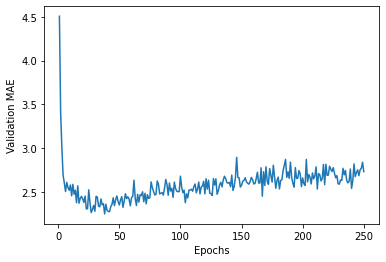

In [27]:
plt.plot(range(1, num_epochs + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [28]:
def moving_average(list1, n=3):

    if n%2 == 0:
        raise ValueError("n has to be an odd integer. n = {} is even".format(n))

    skip = n//2
    l = len(list1)
    list_2 = np.zeros(l)
    for i in range(l):
        c=0
        for j in range(i-skip, i+skip+1):
            if j >= 0 and j < l:
                list_2[i] += list1[j]
                c+=1
        list_2[i]/=c

    return list_2

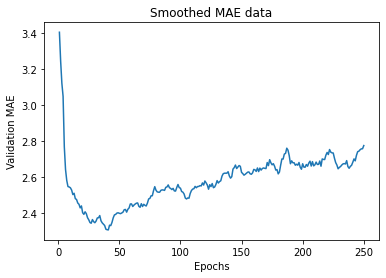

40


In [39]:
smooth_mae_history = moving_average(average_mae_history, 7)
plt.plot(range(1, num_epochs + 1), moving_average(average_mae_history, 7))
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Smoothed MAE data')
plt.show()
print(np.argmin(smooth_mae_history))

We see that overfitting occures after 40 epochs. Let's retrain the network from scratch, this time for only 40 epochs and with all the training data.

In [40]:
num_epochs = 40

# Building the network and fitting it
network = build_model()
history = network.fit(train_data, train_targets, epochs=num_epochs, batch_size=1, verbose=0)

# Evaluating the test data
test_mse, test_mae = network.evaluate(test_data, test_targets)
print(test_mse, test_mae)

4/4 [==============================] - 0s 3ms/step - loss: 15.6737 - mae: 2.5109
15.67373275756836 2.5108582973480225


The model is now off by 2511$.